# Stock Price Prediction Using Sentiment Analysis

~/start_bigdata_env.sh

In [1]:
# ✅ 1. Start Spark session and import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, to_date, col, input_file_name, regexp_extract, trim, upper, avg, count, min, max
from pyspark.sql.types import DoubleType
from textblob import TextBlob

spark = SparkSession.builder \
    .appName("StockSentimentPipeline") \
    .config("spark.cassandra.connection.host", "127.0.0.1") \
    .getOrCreate()

# ✅ 2. Load raw tweets to inspect date format
df_raw_tweets = spark.read.option("header", "true").csv("hdfs:///user/hduser/input/stocktweet.csv")

# Sentiment analysis UDF
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity if text else 0.0

sentiment_udf = udf(get_sentiment, DoubleType())

# ✅ 3. Convert tweet columns: date, sentiment, ticker with correct format
# Format detected: dd/MM/yyyy
df_tweets = df_raw_tweets \
    .withColumn("date", to_date(col("date"), "dd/MM/yyyy")) \
    .withColumn("sentiment_score", sentiment_udf(col("tweet"))) \
    .withColumn("ticker", upper(trim(col("ticker"))))

df_tweets.show(5)

# ✅ 3a. EDA for Tweets
df_tweets.groupBy("ticker").agg(
    count("tweet").alias("tweet_count"),
    avg("sentiment_score").alias("avg_sentiment"),
    min("sentiment_score").alias("min_sentiment"),
    max("sentiment_score").alias("max_sentiment")
).orderBy("ticker").show()

# ✅ 4. Load and prepare stock prices from HDFS
df_prices = spark.read.option("header", "true").csv("hdfs:///user/hduser/input/stockprice/*.csv")
df_prices = df_prices.withColumn("filename", input_file_name())
df_prices = df_prices.withColumn("ticker", regexp_extract(col("filename"), r"([^/]+)\.csv$", 1))

df_prices = df_prices \
    .withColumn("date", to_date(col("Date"))) \
    .withColumn("open_price", col("Open").cast("double")) \
    .withColumn("close_price", col("Close").cast("double")) \
    .withColumn("ticker", upper(trim(col("ticker"))))

df_prices.select("ticker", "date", "open_price", "close_price").show(5)

# ✅ 4a. EDA for Stock Prices
df_prices.groupBy("ticker").agg(
    count("date").alias("days_traded"),
    avg("close_price").alias("avg_close"),
    min("close_price").alias("min_close"),
    max("close_price").alias("max_close")
).orderBy("ticker").show()

# ✅ 5. Filter both datasets for selected companies
tickers = ["AAPL", "TSLA", "MSFT", "GOOGL", "AMZN"]
df_tweets = df_tweets.filter(df_tweets.ticker.isin(tickers))
df_prices = df_prices.filter(df_prices.ticker.isin(tickers))

# ✅ 6. Join tweets and prices on ticker and date
df_joined = df_tweets.join(df_prices, on=["ticker", "date"], how="inner")
df_final = df_joined.select("ticker", "date", "sentiment_score", "close_price")
df_final.orderBy("ticker", "date").show(10)

# ✅ 7. Save final dataset to Cassandra (optional)
df_final.write \
  .format("org.apache.spark.sql.cassandra") \
  .options(table="tweet_price_join", keyspace="stockdata") \
  .mode("append") \
  .save()




25/05/04 14:57:31 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+------+----------+------+--------------------+------------------+
|    id|      date|ticker|               tweet|   sentiment_score|
+------+----------+------+--------------------+------------------+
|100001|2020-01-01|  AMZN|$AMZN Dow futures...|               0.0|
|100002|2020-01-01|  TSLA|$TSLA Daddy's dri...|           0.15625|
|100003|2020-01-01|  AAPL|$AAPL We’ll been ...|               0.0|
|100004|2020-01-01|  TSLA|$TSLA happy new y...|0.4681818181818182|
|100005|2020-01-01|  TSLA|"$TSLA haha just ...|               0.5|
+------+----------+------+--------------------+------------------+
only showing top 5 rows



+--------------------+-----------+--------------------+--------------------+------------------+
|              ticker|tweet_count|       avg_sentiment|       min_sentiment|     max_sentiment|
+--------------------+-----------+--------------------+--------------------+------------------+
|                null|          0|                 0.0|                 0.0|               0.0|
|000 BOTTOM LINE A...|          0|                 0.0|                 0.0|               0.0|
| 116.50????? 😍🙏🏼"|          0|                 0.0|                 0.0|               0.0|
|5K PRICE PREDICTI...|          0|                 0.0|                 0.0|               0.0|
| 902 SHARES @ 233.42|          0|                 0.0|                 0.0|               0.0|
|                AAPL|       1721| 0.09610223810860757|                -1.0|               1.0|
|                ABNB|         60|   0.041583658008658|                -0.6|               0.8|
|                 AMT|          2|-0.075000

+------+----------+-------------------+-----------------+
|ticker|      date|    sentiment_score|      close_price|
+------+----------+-------------------+-----------------+
|  AAPL|2020-01-02|                0.0| 75.0875015258789|
|  AAPL|2020-01-02|0.14285714285714285| 75.0875015258789|
|  AAPL|2020-01-02|                0.0| 75.0875015258789|
|  AAPL|2020-01-02| 0.4681818181818182| 75.0875015258789|
|  AAPL|2020-01-02|             0.1275| 75.0875015258789|
|  AAPL|2020-01-02|                0.0| 75.0875015258789|
|  AAPL|2020-01-02| 0.1722222222222222| 75.0875015258789|
|  AAPL|2020-01-02|               0.25| 75.0875015258789|
|  AAPL|2020-01-03|                0.0|74.35749816894531|
|  AAPL|2020-01-03|                0.2|74.35749816894531|
+------+----------+-------------------+-----------------+
only showing top 10 rows



In [2]:
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window

# ✅ 9. Define window and add previous_close
windowSpec = Window.partitionBy("ticker").orderBy("date")

df_final = df_final.withColumn("previous_close", lag("close_price", 1).over(windowSpec))
df_final = df_final.dropna()

# ✅ 10. Summary statistics
df_final.select("sentiment_score", "close_price", "previous_close").summary().show()

# ✅ 11. Calculate price change and correlation
df_final = df_final.withColumn("price_change", col("close_price") - col("previous_close"))
correlation = df_final.stat.corr("sentiment_score", "price_change")
print(f"Correlation between sentiment and price change: {correlation:.4f}")



+-------+-------------------+------------------+------------------+
|summary|    sentiment_score|       close_price|    previous_close|
+-------+-------------------+------------------+------------------+
|  count|               6478|              6478|              6478|
|   mean| 0.0884440835907846|  109.763676338926|109.70279785290512|
| stddev|0.27112561908917193|  51.0929398439724|  51.0624085520357|
|    min|               -1.0| 24.08133316040039| 24.08133316040039|
|    25%|                0.0| 61.16133117675781| 61.16133117675781|
|    50%|                0.0|113.90249633789062| 113.8499984741211|
|    75%|                0.2|141.41000366210938|141.41000366210938|
|    max|                1.0|235.22332763671875|235.22332763671875|
+-------+-------------------+------------------+------------------+



Correlation between sentiment and price change: 0.0057


In [3]:
import pandas as pd
df_pd = df_final.toPandas()
df_pd["date"] = pd.to_datetime(df_pd["date"])
df_pd = df_pd.sort_values(["ticker", "date"])
df_pd.head()

,ticker,date,sentiment_score,close_price,previous_close,price_change
0,AAPL,2020-01-02,0.142857,75.087502,75.087502,0.0
1,AAPL,2020-01-02,0.000000,75.087502,75.087502,0.0
2,AAPL,2020-01-02,0.000000,75.087502,75.087502,0.0
3,AAPL,2020-01-02,0.172222,75.087502,75.087502,0.0
4,AAPL,2020-01-02,0.000000,75.087502,75.087502,0.0



📈 7-day forecast for AAPL:
2021-01-01    132.705129
2021-01-02    132.655222
2021-01-03    132.667162
2021-01-04    132.667119
2021-01-05    132.675292
2021-01-06    132.674461
2021-01-07    132.675197
Freq: D, Name: predicted_mean, dtype: float64


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

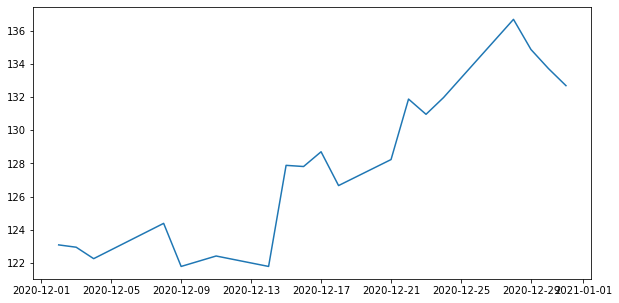

In [4]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

tickers = ["AAPL", "TSLA", "MSFT", "GOOGL", "AMZN"]

for ticker in tickers:
    df_ticker = df_pd[df_pd["ticker"] == ticker].copy()
    df_ticker = df_ticker.groupby("date")["close_price"].mean().sort_index()
    series = df_ticker.asfreq('D').interpolate()  # ensure daily frequency and fill missing values

    model = ARIMA(series, order=(5, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=7)

    print(f"\n📈 7-day forecast for {ticker}:")
    print(forecast)

    # Plot the forecast
    plt.figure(figsize=(10, 5))
    plt.plot(series[-30:], label="Historical")
    forecast_dates = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
    plt.plot(forecast_dates, forecast.to_numpy(), label="Forecast", linestyle="--")
    plt.title(f"{ticker} - 7-Day Close Price Forecast")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

📈 7-day forecast for AAPL:
232    132.720735
233    132.976573
234    132.877135
235    132.871009
236    132.804639
237    132.810081
238    132.822239
Name: predicted_mean, dtype: float64


/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return ge

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

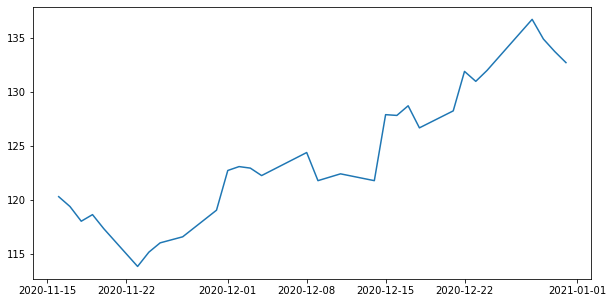

In [5]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


# ✅ 12. Forecast CLOSE price with ARIMA for one stock (e.g., AAPL)
ticker = "AAPL"
df_aapl = df_pd[df_pd["ticker"] == ticker].copy()
df_aapl["close_price"] = pd.to_numeric(df_aapl["close_price"], errors="coerce")
df_aapl = df_aapl.dropna(subset=["close_price"])
df_aapl = df_aapl.groupby("date")["close_price"].mean().sort_index()
series = df_aapl


model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=7)

print("📈 7-day forecast for AAPL:")
print(forecast)

# ✅ 13. Plot actual vs forecast
plt.figure(figsize=(10,5))
plt.plot(series[-30:], label="Historical")
forecast_dates = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
plt.plot(forecast_dates, forecast.to_numpy(), label="Forecast", linestyle="--")
plt.title("AAPL 7-Day Close Price Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
 

📈 7-day forecast for TSLA:
243    235.641919
244    235.871370
245    236.222197
246    235.422083
247    235.141056
248    235.094556
249    235.025778
Name: predicted_mean, dtype: float64


/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return ge

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

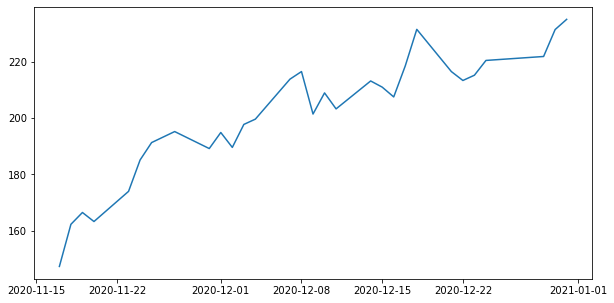

In [6]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


# ✅ 10. Forecast CLOSE price with ARIMA for one stock (e.g., TSLA)
ticker2 = "TSLA"
df_aapl = df_pd[df_pd["ticker"] == ticker2].copy()
df_aapl["close_price"] = pd.to_numeric(df_aapl["close_price"], errors="coerce")
df_aapl = df_aapl.dropna(subset=["close_price"])
df_aapl = df_aapl.groupby("date")["close_price"].mean().sort_index()
series = df_aapl



model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=7)

print("📈 7-day forecast for TSLA:")
print(forecast)

# ✅ 11. Plot actual vs forecast
plt.figure(figsize=(10,5))
plt.plot(series[-30:], label="Historical")
plt.plot(pd.date_range(series.index[-1], periods=7, freq='D')[1:], forecast, label="Forecast", linestyle="--")
plt.title("TSLA 7-Day Close Price Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
 

In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Take the last 7 actual values as test
actual = series[-7:]
predicted = forecast[:7]

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"RMSE for AAPL ARIMA forecast: {rmse:.2f}")


RMSE for AAPL ARIMA forecast: 15.61


/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12917D+00    |proj g|=  7.12627D-02

At iterate    5    f=  3.04303D+00    |proj g|=  5.49199D-02

At iterate   10    f=  3.03016D+00    |proj g|=  1.37256D-03

At iterate   15    f=  3.02971D+00    |proj g|=  1.45585D-02

At iterate   20    f=  3.02944D+00    |proj g|=  2.48973D-03

At iterate   25    f=  3.02866D+00    |proj g|=  4.91203D-03

At iterate   30    f=  3.02548D+00    |proj g|=  4.45627D-02

At iterate   35    f=  3.02337D+00    |proj g|=  1.04342D-02

At iterate   40    f=  3.01958D+00    |proj g|=  3.33379D-02

At iterate   45    f=  3.01866D+00    |proj g|=  5.80817D-02

At iterate   50    f=  3.01844D+00    |proj g|=  8.00490D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

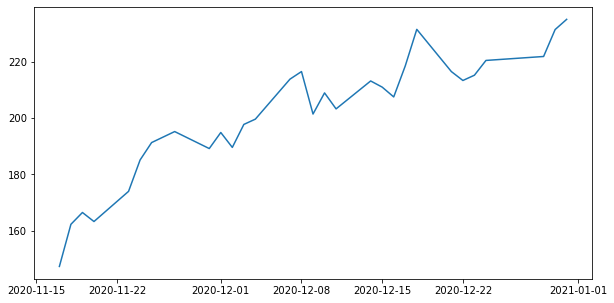

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(series, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.forecast(steps=7)

# Plot
plt.figure(figsize=(10,5))
plt.plot(series[-30:], label="Historical")
plt.plot(forecast_dates, sarima_forecast, label="SARIMA Forecast", linestyle="--")
plt.legend()
plt.show()


In [9]:
ticker_forecasts = {}
for ticker in df_pd['ticker'].unique():
    series = df_pd[df_pd["ticker"] == ticker].set_index("date")["close_price"]
    try:
        model = ARIMA(series, order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=7)
        ticker_forecasts[ticker] = forecast
    except Exception as e:
        print(f"Failed for {ticker}: {e}")


/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return ge

In [10]:
df_sentiment = df_pd.groupby(["ticker", "date"])["sentiment_score"].mean().reset_index()


In [11]:
forecast_df = pd.DataFrame({
    "date": forecast_dates,
    "ticker": ticker,
    "forecasted_price": forecast.values
})
# Save to CSV
forecast_df.to_csv(f"{ticker}_forecast.csv", index=False)



In [12]:
import torch
import torch.nn as nn


ticker = "AAPL"
df_ticker = df_pd[df_pd["ticker"] == ticker].copy()
df_ticker = df_ticker.sort_values("date")
series = df_ticker["close_price"].values.astype(np.float32)

# Normalize
mean = series.mean()
std = series.std()
series = (series - mean) / std

# Create sequences
seq_length = 10
X, y = [], []
for i in range(len(series) - seq_length):
    X.append(series[i:i+seq_length])
    y.append(series[i+seq_length])
X = torch.tensor(X).unsqueeze(-1)
y = torch.tensor(y)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out).squeeze()

model = LSTMModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = loss_fn(output, y)
    loss.backward()
    optimizer.step()

# Forecast
model.eval()
input_seq = torch.tensor(series[-seq_length:]).unsqueeze(0).unsqueeze(-1)
forecast = []
for _ in range(7):
    with torch.no_grad():
        next_val = model(input_seq).item()
    forecast.append(next_val)
    next_tensor = torch.tensor([[next_val]]).unsqueeze(0)
    input_seq = torch.cat((input_seq[:, 1:], next_tensor), dim=1)

# Denormalize
forecast = np.array(forecast) * std + mean
print("7-day forecast for", ticker)
print(forecast)


/tmp/ipykernel_4367/1402216625.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(X).unsqueeze(-1)


7-day forecast for AAPL
[132.9167237  132.79217872 132.6641023  132.51555568 132.38093428
 132.26646572 132.15906513]


In [40]:
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html
from dash.dependencies import Input, Output, State
import pandas as pd
import plotly.graph_objs as go
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_squared_error

# Preprocess the data
df_pd["date"] = pd.to_datetime(df_pd["date"])
df_pd = df_pd.sort_values(["ticker", "date"])

# Dash app with Bootstrap theme
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.LUX, "https://cdn.jsdelivr.net/npm/bootstrap-icons@1.10.3/font/bootstrap-icons.css"])
server = app.server

# Get min/max date range
date_range = pd.date_range(start="2020-01-01", end="2021-01-31")

app.layout = dbc.Container([
    dbc.NavbarSimple(brand="Stock Price Forecast Dashboard", color="info", dark=True, className="mb-4"),

    dbc.Row([
        dbc.Col([
            html.Div([
                dbc.Button(html.I(className="bi bi-arrow-clockwise", style={"color": "green", "fontSize": "1.5rem"}), id="reset-button", color="light", className="rounded-circle border border-success")
            ], className="d-flex justify-content-center align-items-center", style={"height": "100%"})
        ], width=1),
        dbc.Col([
            html.Label("Select a company:", className="text-center w-100"),
            dcc.Dropdown(
                id='ticker-dropdown',
                options=[{"label": t, "value": t} for t in sorted(df_pd["ticker"].unique())],
                value="AAPL"
            )
        ], width=4),
        dbc.Col([
            html.Label("Select date range:", className="text-center w-100"),
            dcc.DatePickerRange(
                id='date-picker-range',
                min_date_allowed=date_range.min(),
                max_date_allowed=date_range.max(),
                start_date=date_range.min(),
                end_date=date_range.max()
            )
        ], width=7)
    ], className="mb-4"),

    dbc.Row([
        dbc.Col(dcc.Graph(id="forecast-graph"), width=12)
    ]),

    dbc.Row(id="insights-output", className="mb-4 justify-content-center g-3", style={"textAlign": "center"}),

    dbc.Row([
        dbc.Col([
            html.Label("Compare sentiment with:", className="text-center w-100 mt-4"),
            dcc.Dropdown(
                id='compare-dropdown',
                options=[{"label": t, "value": t} for t in sorted(df_pd["ticker"].unique())],
                value=["AAPL", "TSLA"],
                multi=True
            )
        ], width=12)
    ], className="mb-4"),

    dbc.Row([
        dbc.Col(width=1, children=[
            html.Div([
                html.Div("↑", style={"fontSize": "2rem", "textAlign": "center", "color": "green", "marginBottom": "5px"}),
                html.Div(style={
                    "height": "250px", "width": "6px",
                    "background": "linear-gradient(to top, red, white, green)",
                    "margin": "0 auto"
                }),
                html.Div("↓", style={"fontSize": "2rem", "textAlign": "center", "color": "red", "marginTop": "5px"}),
                html.Div("Very positive", className="text-center", style={"fontSize": "0.6rem", "marginTop": "4px"}),
                html.Div("Neutral", className="text-center", style={"fontSize": "0.6rem", "marginTop": "6px"}),
                html.Div("Very negative", className="text-center", style={"fontSize": "0.6rem", "marginTop": "6px"})
            ], style={"display": "flex", "flexDirection": "column", "alignItems": "center"})
        ]),
        dbc.Col([
            dcc.Graph(id="sentiment-comparison-graph")
        ], width=11)
    ])

], fluid=True, style={"backgroundColor": "#f4f9f9", "paddingBottom": "30px"})


@app.callback(
    [Output("forecast-graph", "figure"),
     Output("sentiment-comparison-graph", "figure"),
     Output("insights-output", "children"),
     Output("ticker-dropdown", "value"),
     Output("compare-dropdown", "value"),
     Output("date-picker-range", "start_date"),
     Output("date-picker-range", "end_date")],
    [Input("ticker-dropdown", "value"),
     Input("compare-dropdown", "value"),
     Input("date-picker-range", "start_date"),
     Input("date-picker-range", "end_date"),
     Input("reset-button", "n_clicks")],
    [State("ticker-dropdown", "value"),
     State("compare-dropdown", "value")]
)
def update_dashboard(ticker, compare_tickers, start_date, end_date, reset_clicks, state_ticker, state_compare):
    ctx = dash.callback_context
    if ctx.triggered and ctx.triggered[0]['prop_id'].startswith("reset-button"):
        ticker = "AAPL"
        compare_tickers = ["AAPL", "TSLA"]
        start_date = "2020-01-01"
        end_date = "2021-01-31"

    df_filtered = df_pd[(df_pd["ticker"] == ticker) & (df_pd["date"] >= start_date) & (df_pd["date"] <= end_date)].copy()
    df_filtered = df_filtered.groupby("date")["close_price"].mean()
    df_filtered = df_filtered.asfreq("D").ffill()

    # ARIMA
    arima_model = ARIMA(df_filtered, order=(5, 1, 0)).fit()
    arima_forecast = arima_model.forecast(steps=7)

    # LSTM
    series = df_filtered.values.astype(np.float32)
    mean, std = series.mean(), series.std()
    series_norm = (series - mean) / std

    seq_len = 10
    X, y = [], []
    for i in range(len(series_norm) - seq_len - 7):
        X.append(series_norm[i:i+seq_len])
        y.append(series_norm[i+seq_len])
    X = torch.tensor(np.array(X)).unsqueeze(-1)
    y = torch.tensor(np.array(y))

    class LSTM(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(input_size=1, hidden_size=50, batch_first=True)
            self.fc = nn.Linear(50, 1)
        def forward(self, x):
            out, _ = self.lstm(x)
            return self.fc(out[:, -1, :]).squeeze()

    model = LSTM()
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for _ in range(100):
        model.train()
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

    model.eval()
    input_seq = torch.tensor(series_norm[-(seq_len+7):-7]).unsqueeze(0).unsqueeze(-1)
    lstm_pred = []
    for _ in range(7):
        with torch.no_grad():
            pred = model(input_seq).item()
        lstm_pred.append(pred)
        input_seq = torch.cat((input_seq[:, 1:], torch.tensor([[[pred]]])), dim=1)
    lstm_forecast = np.array(lstm_pred) * std + mean

    future_dates = pd.date_range(start=df_filtered.index[-1] + pd.Timedelta(days=1), periods=7)

    # Main Graph
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_filtered.index, y=df_filtered, name="Historical"))
    fig.add_trace(go.Scatter(x=future_dates, y=arima_forecast, name="ARIMA Forecast"))
    fig.add_trace(go.Scatter(x=future_dates, y=lstm_forecast, name="LSTM Forecast"))
    fig.update_layout(title=dict(text=f"{ticker} Forecast (ARIMA vs LSTM)", x=0.5, font=dict(color="teal")),
                      height=500, paper_bgcolor="#f4f9f9")

    # Sentiment comparison
    df_sent = df_pd[(df_pd["ticker"].isin(compare_tickers)) & (df_pd["date"] >= start_date) & (df_pd["date"] <= end_date)]
    sentiment_plot = go.Figure()
    for t in compare_tickers:
        df_grouped = df_sent[df_sent["ticker"] == t].groupby("date")["sentiment_score"].mean().reset_index()
        sentiment_plot.add_trace(go.Scatter(x=df_grouped["date"], y=df_grouped["sentiment_score"], name=t))
    sentiment_plot.update_layout(title=dict(text="Sentiment Comparison", x=0.5),
                                 height=400, paper_bgcolor="#f4f9f9")

    # Insights
    avg_price = df_filtered.mean()
    max_price = df_filtered.max()
    min_price = df_filtered.min()
    mse_arima = mean_squared_error(df_filtered[-7:], arima_forecast[:7])
    mse_lstm = mean_squared_error(df_filtered[-7:], lstm_forecast[:7])

    insights = dbc.Row([
        dbc.Col(dbc.Card([
            dbc.CardBody([
                html.H6("Avg Price", className="card-title text-center"),
                html.H4(f"${avg_price:.2f}", className="text-center")
            ])
        ], color="info", inverse=True), width=2),
        dbc.Col(dbc.Card([
            dbc.CardBody([
                html.H6("Max Price", className="card-title text-center"),
                html.H4(f"${max_price:.2f}", className="text-center")
            ])
        ], color="success", inverse=True), width=2),
        dbc.Col(dbc.Card([
            dbc.CardBody([
                html.H6("Min Price", className="card-title text-center"),
                html.H4(f"${min_price:.2f}", className="text-center")
            ])
        ], color="danger", inverse=True), width=2),
        dbc.Col(dbc.Card([
            dbc.CardBody([
                html.H6("ARIMA MSE", className="card-title text-center"),
                html.H4(f"{mse_arima:.4f}", className="text-center")
            ])
        ], color="primary", inverse=True), width=2),
        dbc.Col(dbc.Card([
            dbc.CardBody([
                html.H6("LSTM MSE", className="card-title text-center"),
                html.H4(f"{mse_lstm:.4f}", className="text-center")
            ])
        ], style={"backgroundColor": "#e6ccff", "color": "#000"}), width=3)
    ], className="mb-4 justify-content-center")

    return fig, sentiment_plot, insights, ticker, compare_tickers, start_date, end_date

if __name__ == "__main__":
    app.run(debug=True)
